In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

(registration)=
# Image registration

The last major topic we will cover in this chapter is image registration. Image
registration is something we do when we have two images that contain parts that
should overlap with each other, but do not. For example, consider what happens
when you take two photos of the same person. If your camera moves between the
two photos, or the person moves between the two photos, their image will be in a
slightly different part of the frame in each of the photos. Or, if you zoom
closer between the photos, their face might take up more space in the photo.
Other parts of the image that appear in the background might also be displaced.
Let's look at an example of this. We will load two photos taken in close
succession. In between the two photos, both the camera and the object of the
photos moved. This means that the two images look a little bit different. This
is apparent if we display the images side-by-side, but becomes even more
apparent when we create a "stereo" image from the two images. This is done by
inserting each of the images into different channels in an RGB image. In this
stereo image (furthest on the right), the contents of the first photo appear in
red, and the contents of the second photo appear in green. Where their contents
are similar, these will blend to yellow.

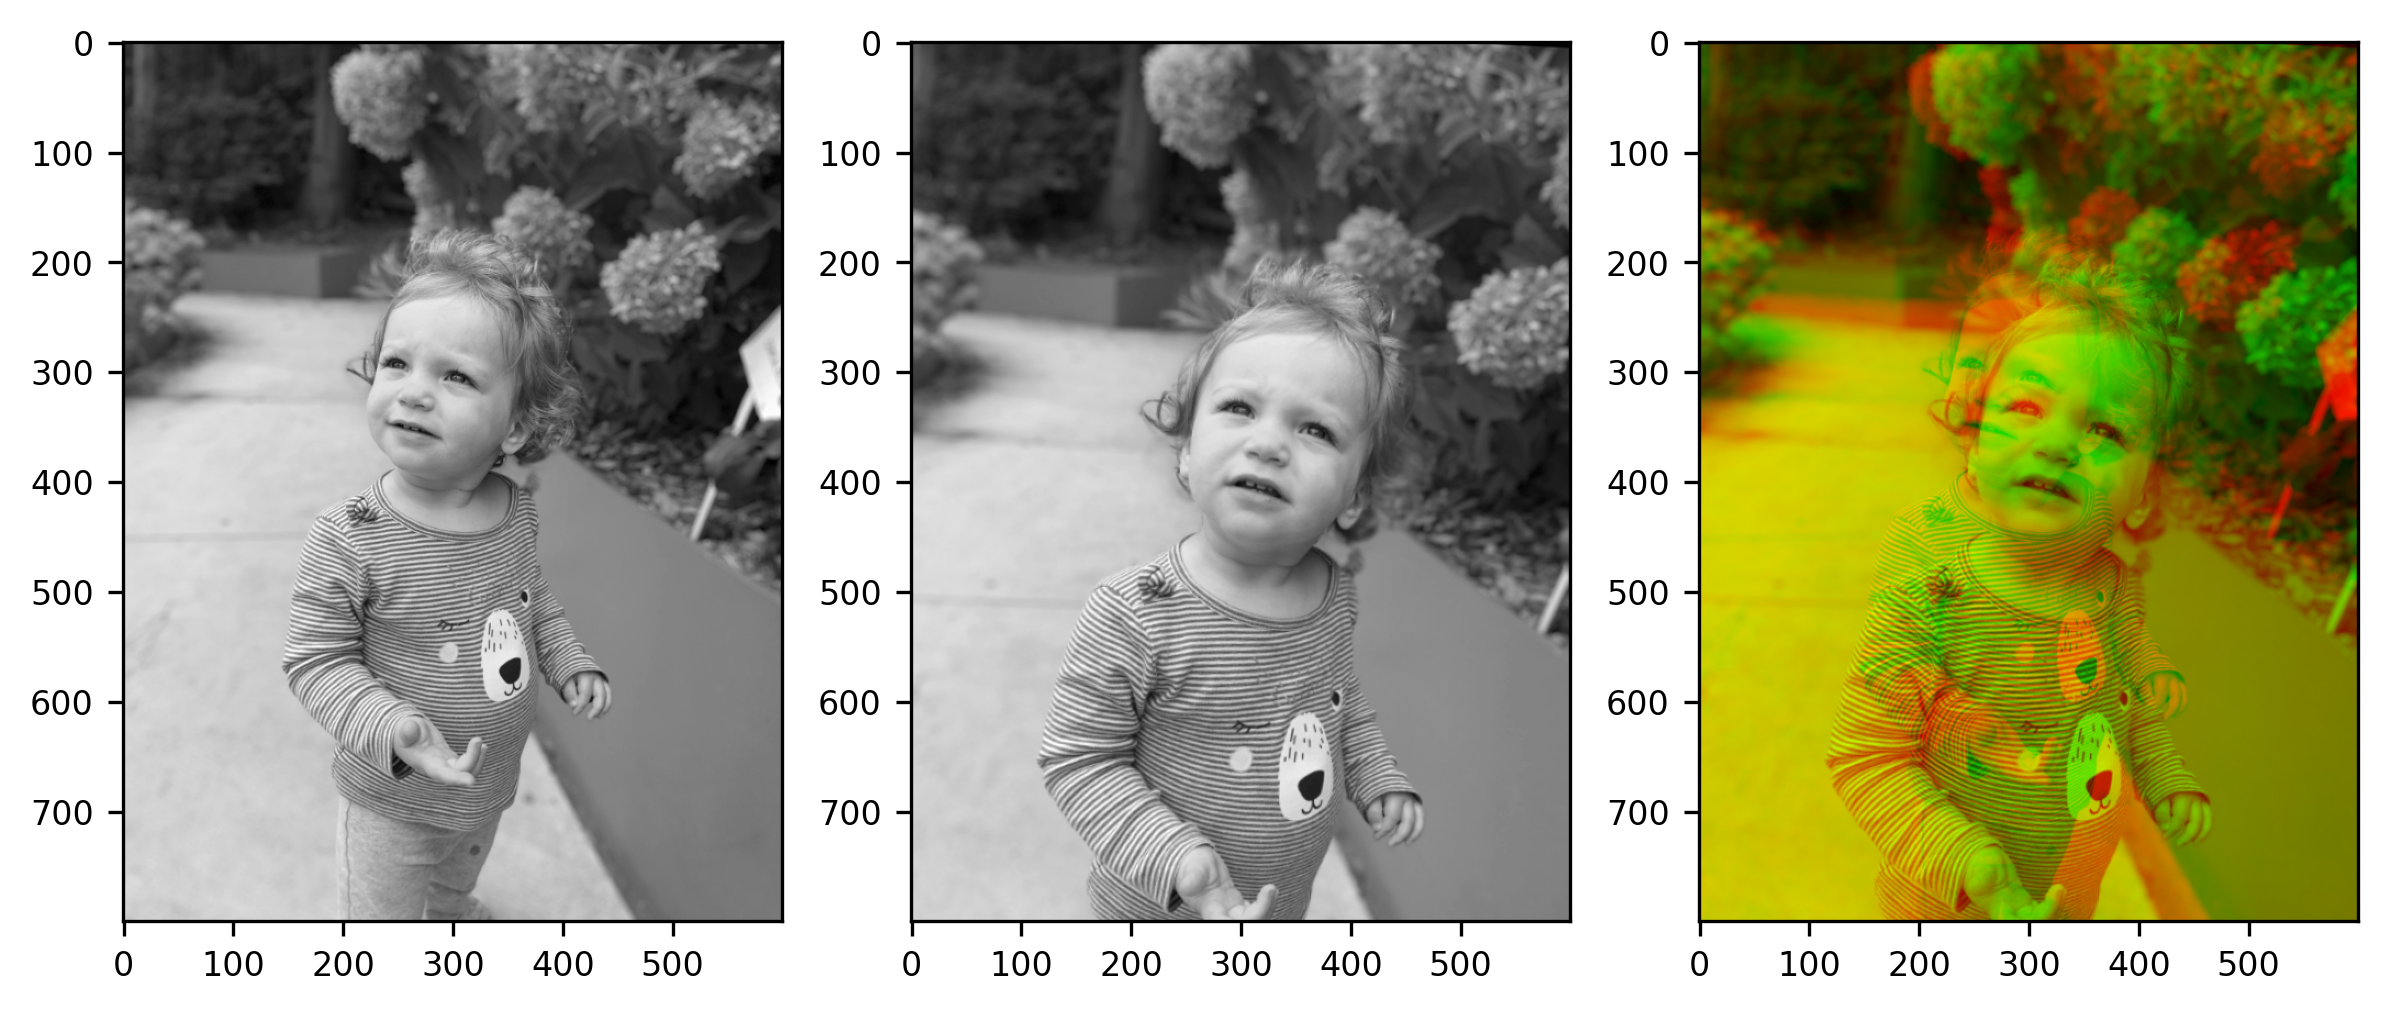

In [2]:
from skimage.io import imread

naomi1 = imread('./figures/naomi1_xform.png')
naomi2 = imread('./figures/naomi2_xform.png')

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(naomi1)
ax[1].imshow(naomi2)

import numpy as np
stereo = np.zeros((800, 600, 3), dtype=np.uint8)
stereo[..., 0] = naomi1
stereo[..., 1] = naomi2
ax[2].imshow(stereo)

fig.tight_layout()

```{note}

The raw image files used in the code snippet above can be downloaded from [this link](https://neuroimaging-data-science.org/_images/naomi1_xform.png) (naomi_xform1.png) and
[this link](https://neuroimaging-data-science.org/_images/naomi2_xform.png) (naomi_xform2.png).

```

As it is, parts of the image that should overlap in the combined image are
pretty far from each other. To make these parts overlap, we have to change one
of the images. This change can be a shift in the location of parts of the image,
it can be a rescaling of the image, such as a zoom in or out, or it can be a
rotation. As you will see later on, in some cases we will want to introduce
changes to the image that are even stranger than that, to account for local
changes, such as the fact that the person in these photos moved their head
between the two photos. But first of all, what is this good for?

This relates to something that we discussed in {numref}`nibabel`: In many
experiments that we do in neuroimaging we collect images of the brain that
represent different aspects of brain function and structure. For example, in a
functional MRI experiment, we might collect images that are sensitive to the
BOLD contrast. In the same experimental session, we might also collect images
that represent an anatomical contrast. For example, it is common to collect
T1-weighted images that we can use to distinguish between parts of the brain
that contain the cell bodies in the gray matter from nearby parts of the brain
that contain the axons in the white matter. In our previous discussion of this
topic, in {numref}`nibabel`, we showed how information is stored in the header
of the NIfTI file that allows us to align two images to each other, even if the
acquisition volumes differed between the two data types in terms of the voxel
size, the field of view and the orientation of the image slices. In our previous
discussion, we set aside a major problem: what do we do if our subject moves
between the acquisition of the BOLD fMRI data and the T1-weighted data? Or
between different volumes of the same BOLD acquisition? In these cases, image
registration methods are used to calculate how we need to move images toward
each other so that they maximally overlap.


## Affine registration

```{eval-rst}
.. index::
   single: Affine
```

The first kind of registration that we will talk about corrects for changes
between the images that affect all of the content in the image. The fact that
the person in the photo is in a different part of the frame, as are details of
the background: the fence above and to the right of their shoulder and the path
winding to the left of them in the image. In this case, these global changes are
mostly affected by the motion of the camera between the two photos. In the case
of brain imaging, a global change to the position of the brain is mostly related
to the fact that the subject moved between the time in which each of the images
was acquired. We will see some examples with brain data further down, but let's
keep going with our photographic example for now.

An affine registration can correct for global differences between images by
applying a combination of transformations on the image: translating the entire
image up or down, to the left or the right; rotating it clockwise or
counter-clockwise, scaling the image (zooming in or out), and shearing the
image. While most of these are straightforward to understand, the last one is a
bit more complex: *image shearing* means that different parts of the image move
tos different degrees. It is simplest to understand by considering a horizontal
shear. In one example of a horizontal shear, the top row of pixels doesn't move
at all, the second row moves by some amount, the third row moves by that amount,
and a small amount more, and so on. A larger amount of shear means that as we go
down the image subsequent rows of pixels move by more and more. For example,
here are images with the amount of horizontal shear increasing from left (the
original image, with no shear) to right (maximal shear):

![](./figures/shears.png)

Affine registration does relate to the affine transformation described in
{numref}`nibabel`. In that chapter, we used affine transformations to *align*
two images, which might have different spatial resolutions, fields of view, and
orientations, when a common reference frame is known to exist -- the scanner
space. Here, we will use an affine to register two images to each other, even
without the need for a common reference frame. But, because we don't have a
common reference frame, we don't know in advance what the values in the
transformation need to be. Instead, we will usually try to find out what are the
correct parameters for this transformation via a process of optimization.
Without going into a full explanation of this process, optimization is generally
the way for a program to find the right set of parameters for a particular
problem. Most optimization procedures work by trying out some values of the
parameters -- the values of the affine transform, in this case -- and then
adjusting the parameters to lower the value of a *cost function*. The process
continues until the algorithm finds the minimal value of this cost function. For
registration, the cost function is usually how different the images are from
each other when transformed using the current affine parameters.

```{eval-rst}
.. index::
   single: Diffusion Imaging in Python (DIPY)
```

To demonstrate this, we will use the [DIPY](https://dipy.org/) software library.
DIPY (Diffusion Imaging in Python) is a software library that implements methods
in computational neuroimaging. As the name suggests, it includes many methods
for the analysis of diffusion MRI data, but it also includes methods that are
useful well beyond diffusion MRI, including methods for image registration.

We'll start with 2D image registration, applied to these photographs. We start
by importing two objects: one that represents the affine transformation in 2D
and another that implements the registration optimization procedure.

In [3]:
from dipy.align.transforms import AffineTransform2D
from dipy.align.imaffine import AffineRegistration

Each of these objects is initialized and an optimization procedure is performed
with the two images and the expected transform (the 2D affine transform) as
input, as well as a required setting for the initial parameters for the
optimization (`param0`). Sometimes, we have some information to tell us where to
initialize this optimization (for example, based on the alignment of the two
images in the scanner; see {numref}`nibabel`). In this case, we don't have any
information to tell us what these initial parameters should be, so we pass
`None`.

In [4]:
affreg = AffineRegistration()
transform = AffineTransform2D()
affine = affreg.optimize(naomi1, naomi2, transform, params0=None)

Optimizing level 2 [max iter: 10000]


Optimizing level 1 [max iter: 1000]


Optimizing level 0 [max iter: 100]


After optimization, the `optimize()` method has determined the parameters of the
affine, and we can apply the transform to one of the images and visualize the
results in the same format that we used above.

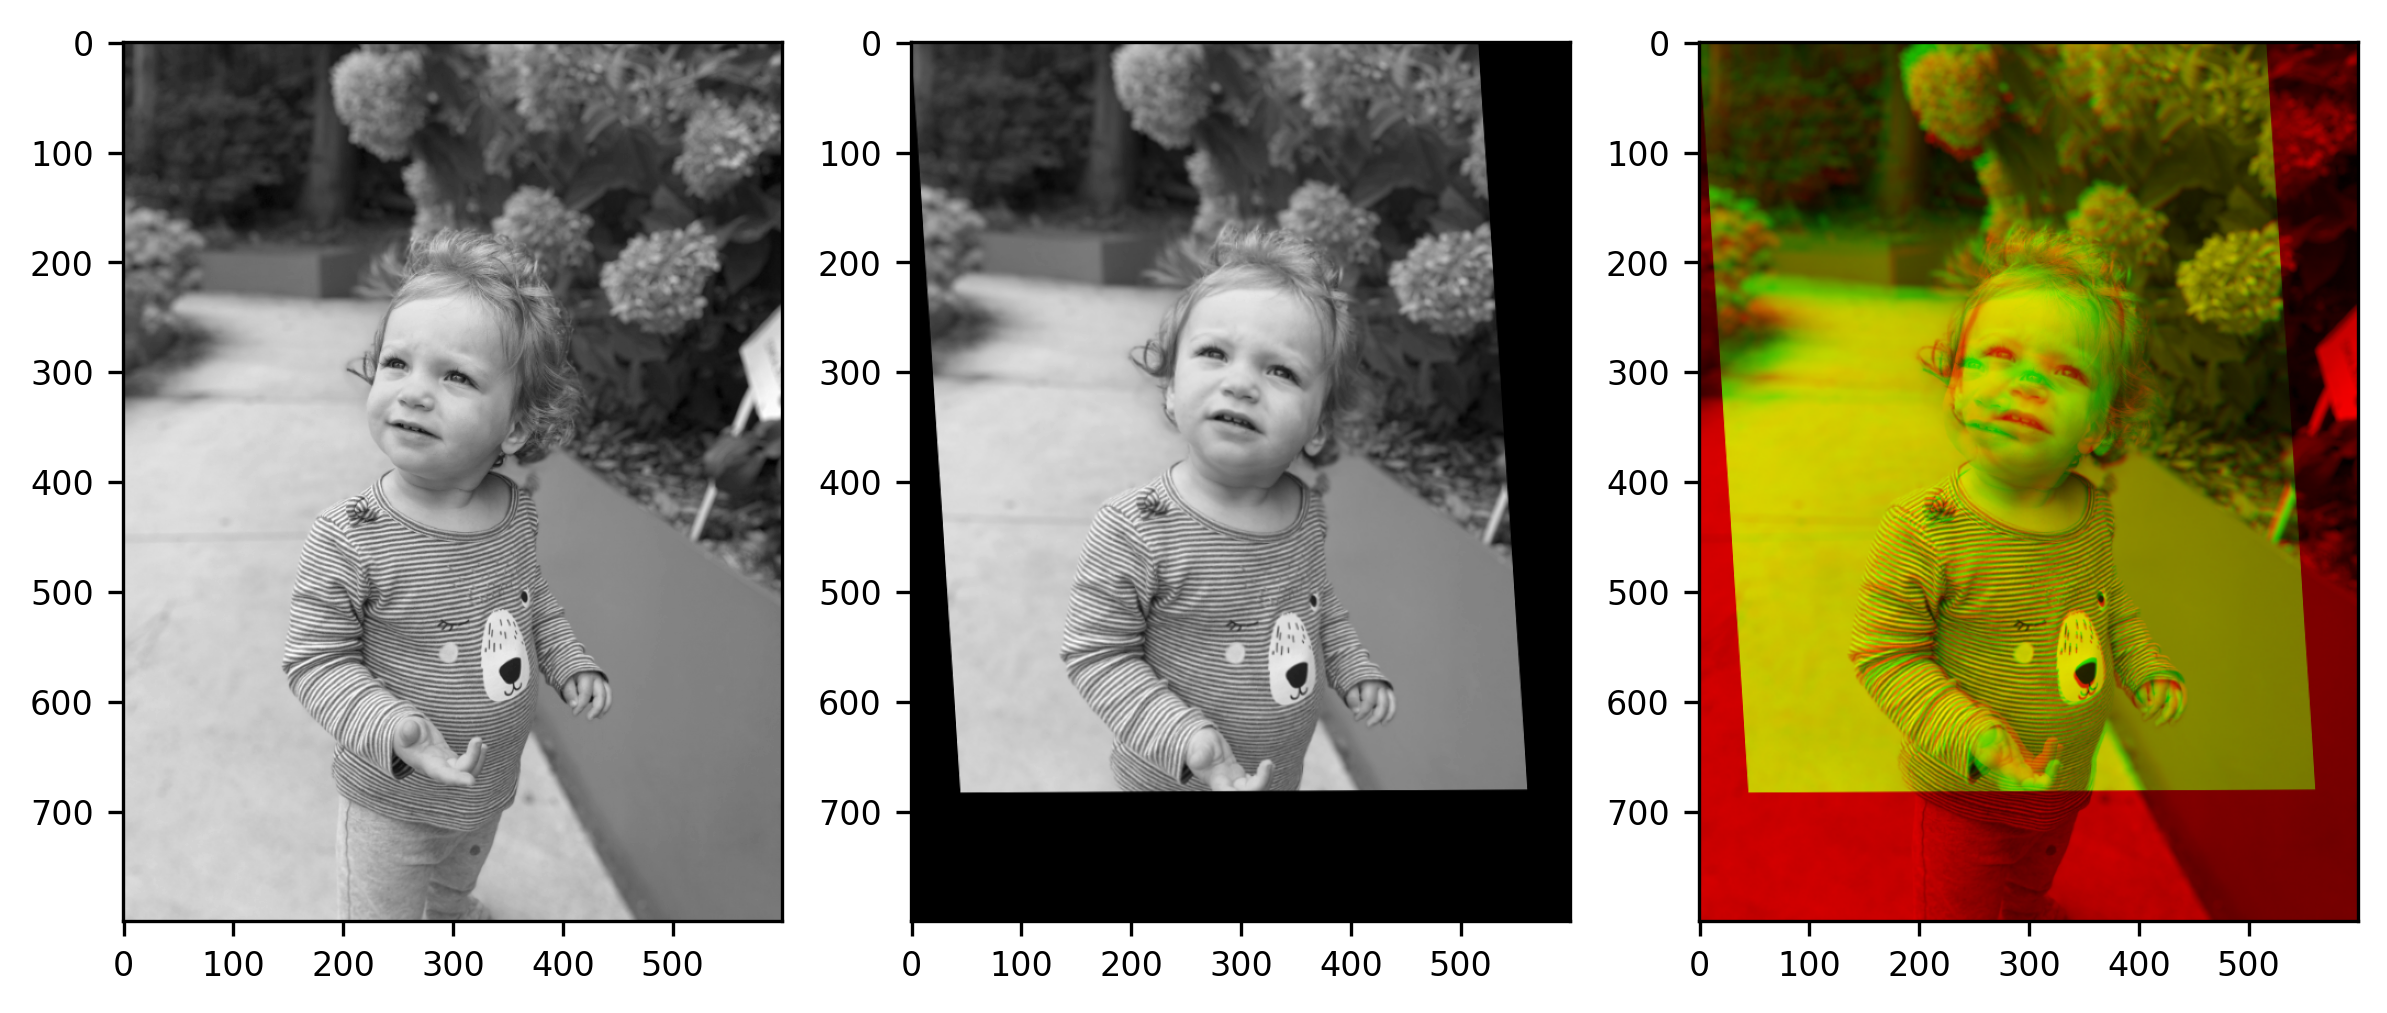

In [5]:
naomi2_xform = affine.transform(naomi2)

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(naomi1)
ax[1].imshow(naomi2_xform)

stereo = np.zeros((800, 600, 3), dtype=np.uint8)
stereo[..., 0] = naomi1
stereo[..., 1] = naomi2_xform
ax[2].imshow(stereo)
fig.tight_layout()

This works rather well, for some parts of the image. Particularly parts of the
image that didn't move much between the two photographs. Unfortunately, the
subject of the photo also moved in a way that could not be captured by the
affine transformation. This is apparent in parts of the face that could not be
registered using the affine transform. Below, we'll see another way of
registering images that can capture some of these discrepancies. But first,
let's see how this applies to neuroimaging data.


### Affine registration of brain images

Another situation that requires that *register* brain images to each other is
when we want to put a specific subject's brain in register with a template. We
do this when we are using an atlas contain that contains information that we
would like to use in the individual brain -- for example a brain parcellation
that is available in the template space and we would like to apply it to the
individual brain. Another case is when we want all of the subjects in a study to
correspond to each other. For example, when we want to summarize the data across
subjects in every location.

Let's see an example of that. We'll use the [`templateflow` software library](https://www.templateflow.org/) -- a software library that gives uniform access to a variety of templates -- to download and load into memory the [MNI152 template](http://nist.mni.mcgill.ca/icbm-152-nonlinear-atlases-2009/).

```{eval-rst}
.. index::
   single: Templateflow
```

In [6]:
import templateflow.api as tflow
import nibabel as nib

mni_img = nib.load(tflow.get('MNI152NLin2009cAsym', resolution=1, suffix="T1w", desc=None))
mni_data = mni_img.get_fdata()

  0%|          | 0.00/13.7M [00:00<?, ?B/s]

 69%|██████▉   | 9.49M/13.7M [00:00<00:00, 94.9MB/s]

100%|██████████| 13.7M/13.7M [00:00<00:00, 106MB/s] 

We will also download and open the T1-weighted image

In [7]:
from ndslib.data import download_bids_dataset
download_bids_dataset()
t1_img = nib.load("ds001233/sub-17/ses-pre/anat/sub-17_ses-pre_T1w.nii.gz")

We will start by aligning the images into the same space, using the same method that we used in {numref}`nibabel`. In this case, we are aligning the T1-weighted image into the space of the template:

In [8]:
from nibabel.processing import resample_from_to
t1_resampled = resample_from_to(t1_img, (mni_img.shape, mni_img.affine))
t1_resamp_data = t1_resampled.get_fdata()

We can use a similar method to the one we used to compare the photos to
visualize the similarity between these brain images, slicing through the 3D
image and visualizing just one axial slice roughly halfway through the volume.
For the composite image, we're also going to have to normalize the images
(dividing each one by its maximal value and multiplying by 255), so that they
are roughly in the same range and blend nicely.

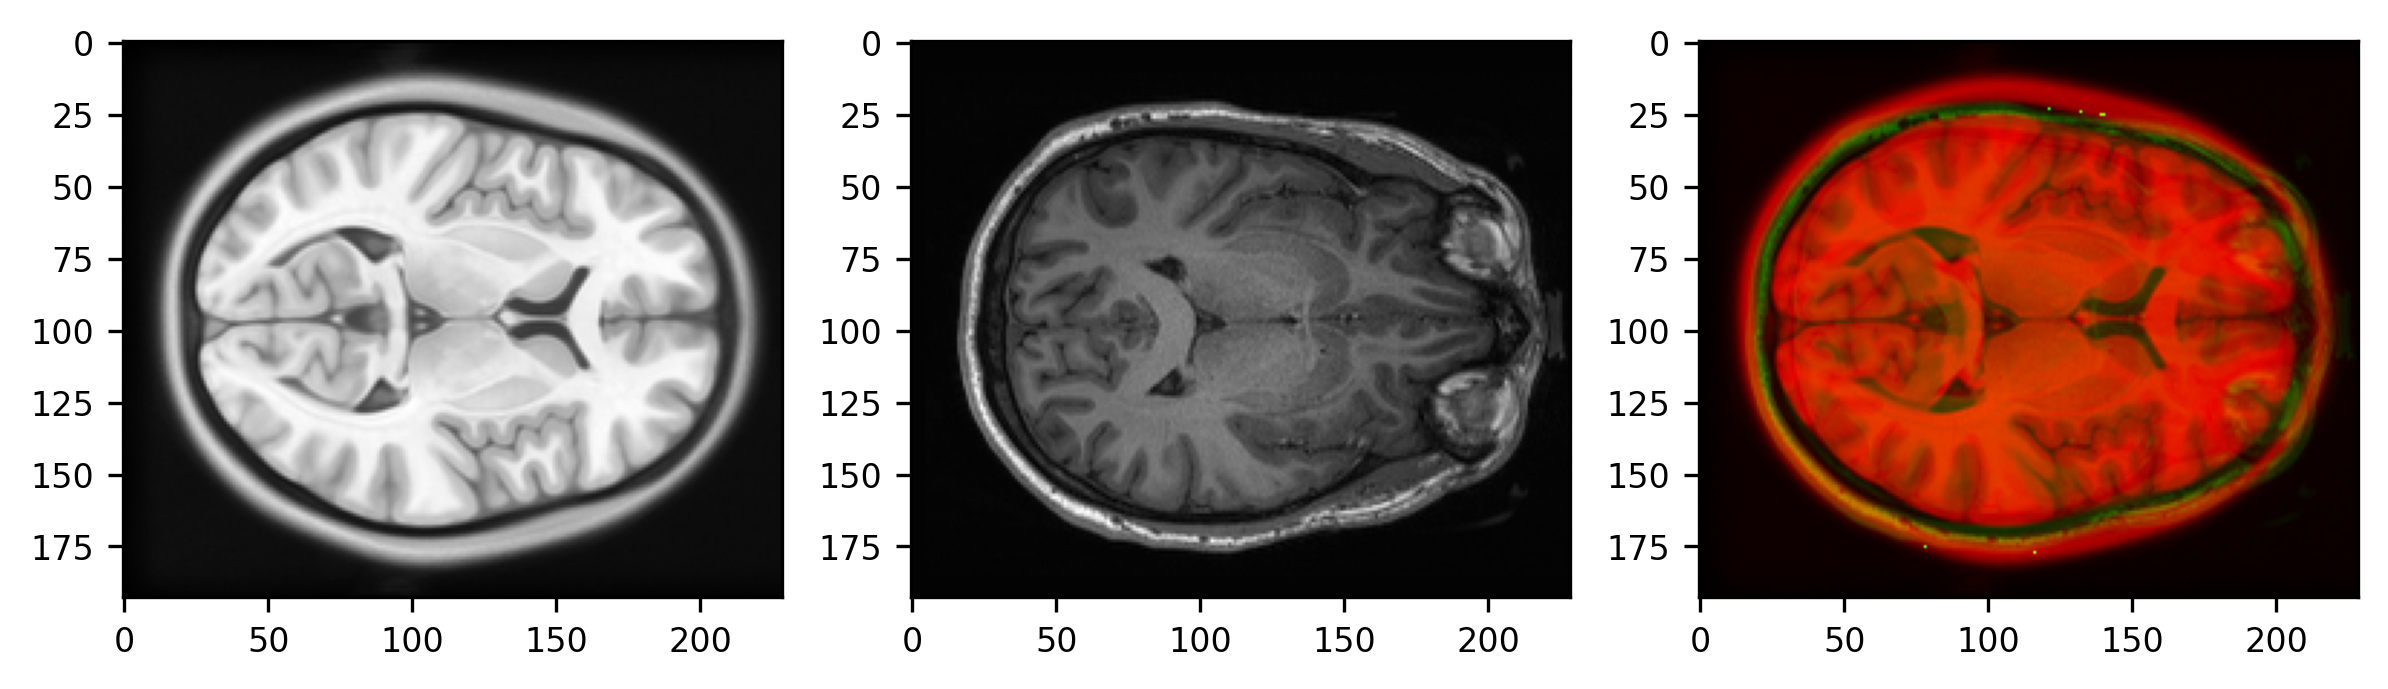

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(mni_data[:, :, 85])
ax[1].imshow(t1_resamp_data[:, :, 85])

stereo = np.zeros((193, 229, 3), dtype=np.uint8)
stereo[..., 0] = 255 * mni_data[:, :, 85]/np.max(mni_data)
stereo[..., 1] = 255 * t1_resamp_data[:, :, 85]/np.max(t1_resamp_data)
ax[2].imshow(stereo)
fig.tight_layout()

We can see that at this point, the brain is not well-registered to the template.
For example, the subject's eyes in the T1-weighted image are where the frontal
lobes are in the template.

We'll use the same code that we used for the affine registration of the
photographs before, with just one small change: Instead of using the
`AffineTransform2D` object, we will use the `AffineTransform3D` to register the
two volumes to each other.

In [10]:
from dipy.align.transforms import AffineTransform3D
affine3d = affreg.optimize(mni_data, t1_resamp_data, AffineTransform3D(), params0=None)
t1_xform = affine3d.transform(t1_resamp_data)

Optimizing level 2 [max iter: 10000]


Optimizing level 1 [max iter: 1000]


Optimizing level 0 [max iter: 100]


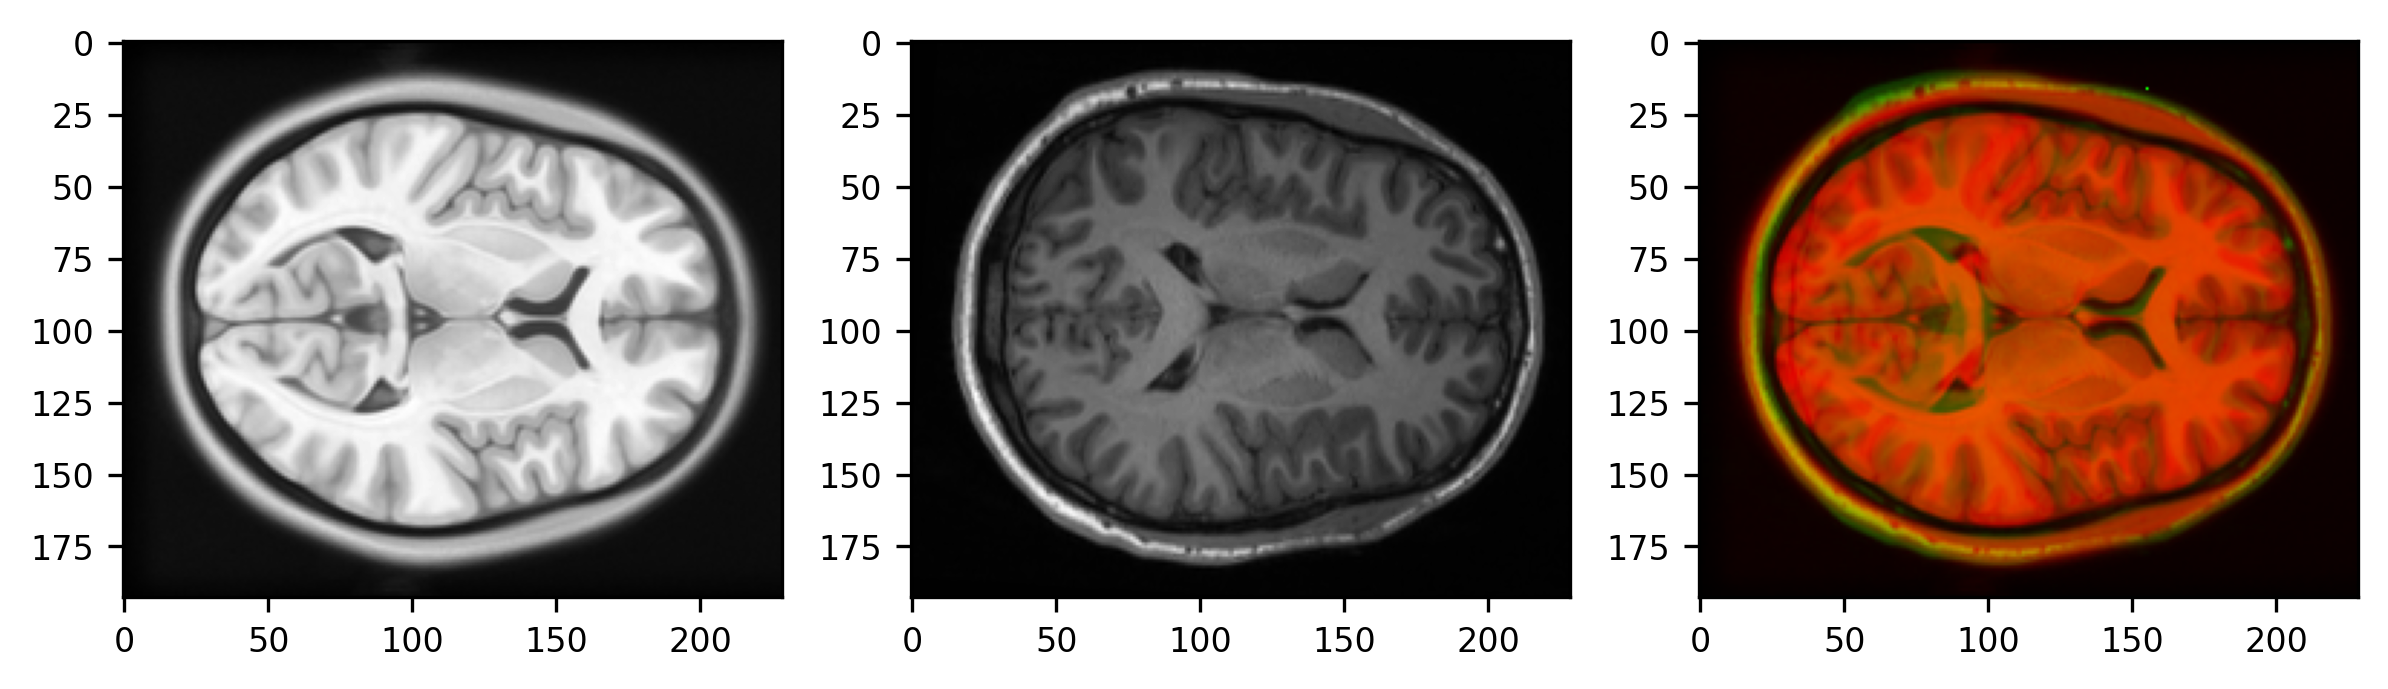

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(mni_data[:, :, 85]/np.max(mni_data))
ax[1].imshow(t1_xform[:, :, 85]/np.max(t1_xform))

stereo = np.zeros((193, 229, 3), dtype=np.uint8)
stereo[..., 0] = 255 * mni_data[:, :, 85]/np.max(mni_data)
stereo[..., 1] = 255 * t1_xform[:, :, 85]/np.max(t1_xform)
ax[2].imshow(stereo)
fig.tight_layout()

This is already not too bad -- see those front lobes -- and might be good enough
for many applications, but you can also see that some details are still off. For
example, the occipital horns of the lateral ventricles extend much further back
in the template than in the subject T1 image. Many of the gyri and sulci of the
cortex are also off. The question is: what more can we do?

### Diffeomorphic registration

```{eval-rst}
.. index::
   single: Diffeomorphic registration
```

As you saw in the results of the affine registration, this kind of "global"
registration approach does well in registering the overall structure of one
brain image to another, but it doesn't necessarily capture differences in small
details. Another family of registration algorithms registers different parts of
the image separately. In principle, you can imagine that each pixel in the first
image could independently move to any location in the second image. But using
this unconstrained approach, in which you can move every pixel in one image to
any location in the other image, you haven't registered the images to
each other, you've replaced them.

Diffeomorphic registration is an approach that balances this flexibility with
constraints. In principle, every pixel/voxel in the moving image could be moved
to overlap with any pixel/voxel in the static image, but neighboring
pixels/voxels are constrained to move by a similar amount. That is, the mapping
between the moving and the static image varies smoothly in space. To demonstrate
this, we'll use the DIPY implementation of an algorithm that learns this kind of
transformation between two images, the Symmetric Normalization algorithm, or SyN
{cite}`Avants2008-sa`. The API for this algorithm is slightly different because
you need to explicitly define the metric that the algorithm uses to figure out
whether the images are similar enough to each other, as part of the optimization
procedure. Here, we are going to use the cross-correlation between the images,
using the `CCMetric` object to define this. This metric also has some other
parameters that need to be defined, a smoothing kernel that is applied to the
image and the size of a window of pixels over which the metric is calculated.

```{eval-rst}
.. index::
   single: Symmetric normalization (SyN) algorithm
```

In [12]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric

metric = CCMetric(2, sigma_diff=20, radius=20)
sdr = SymmetricDiffeomorphicRegistration(metric)

After the diffeomorphic registration object is defined, the computation is
executed using code that is very similar to what we saw for affine registration.
We also pass along a pre-alignment of the two images, based on the affine
registration. This is a good idea, as the diffeomorphic registration is very
flexible, and we want to make sure that it registers local details to each other
without warping the overall shape of the objects in the image (try removing that
argument and run this again to convince yourself that it is indeed a good idea)

In [13]:
mapping = sdr.optimize(naomi1, naomi2, prealign=affine.affine)
naomi2_warped = mapping.transform(naomi2)

In some respects, the result is not that different from the affine registration
of these two images. Features that were pretty well-registered before, remain
pretty nicely registered. But in some places, a bit of distortion has been
introduced, to better align some of the local features.

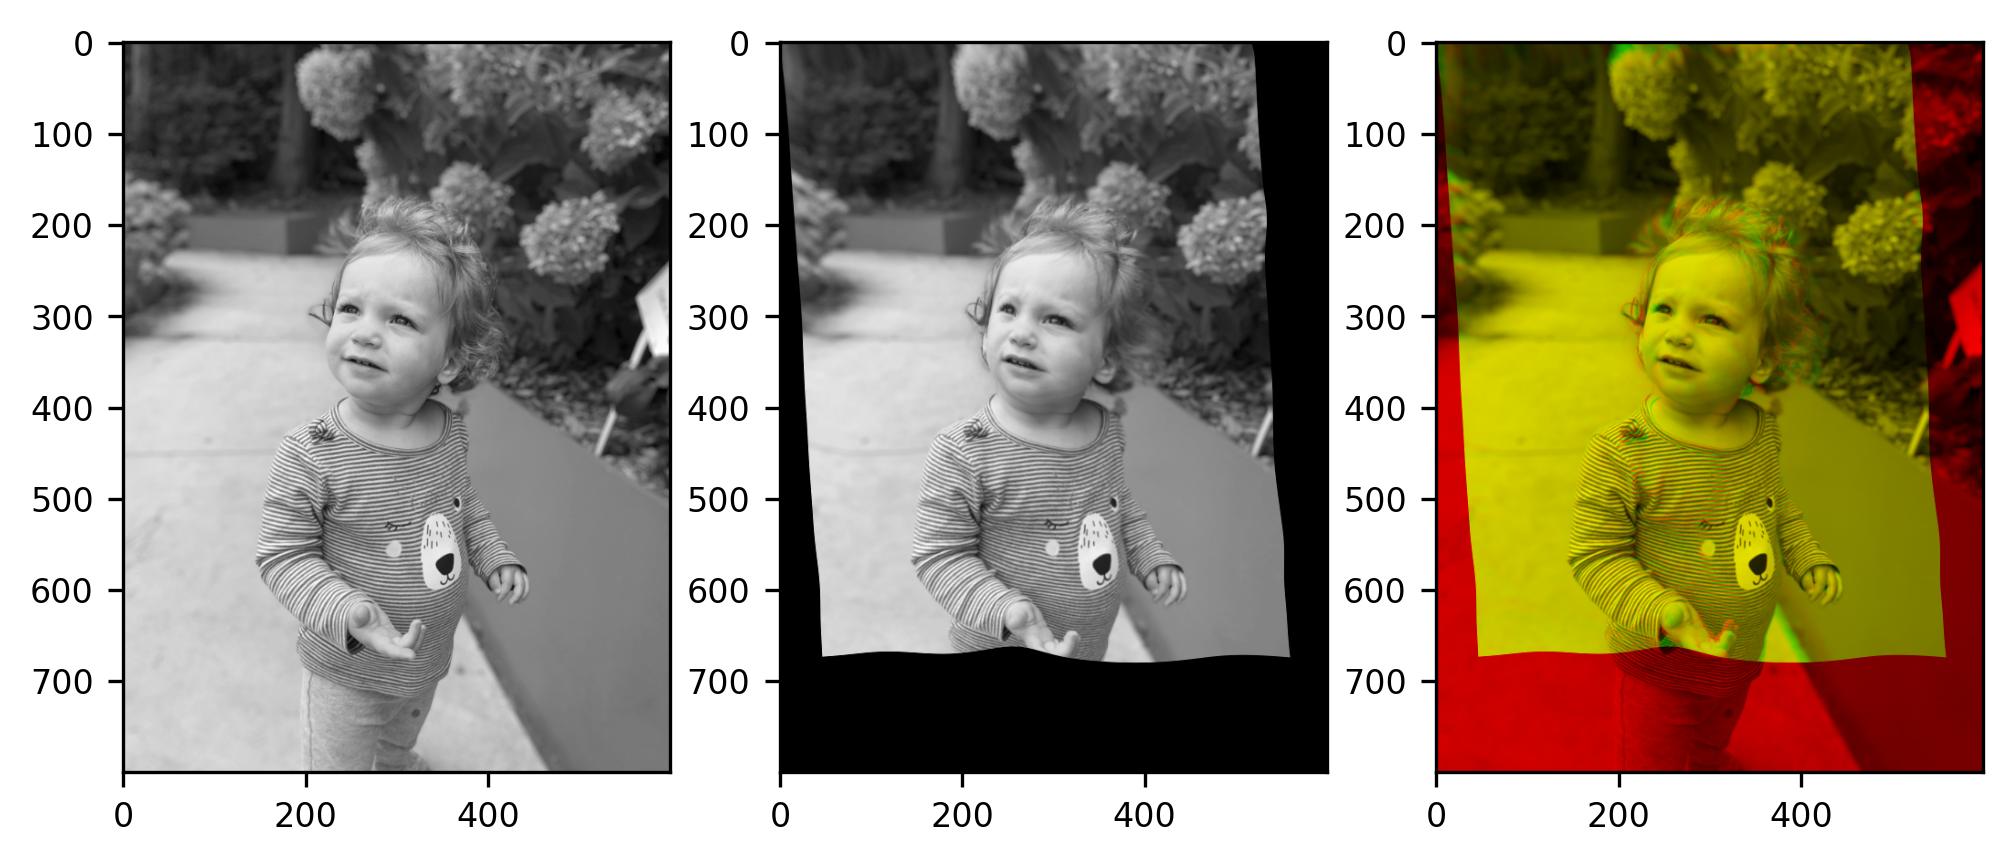

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(naomi1)
ax[1].imshow(naomi2_warped)

stereo = np.zeros((800, 600, 3), dtype=np.uint8)
stereo[..., 0] = naomi1
stereo[..., 1] = naomi2_warped
im = ax[2].imshow(stereo)

To explore this idea a bit more, we can visualize the *displacement field*
between the two images, an image that describes how much each pixel moved as a
result of the registration. In places where no displacement occurs, this looks
like a regular grid. In places where there is a local distortion, the grid is
distorted accordingly. This should give you a feel for the kinds of
transformations that a diffeomorphism can create.

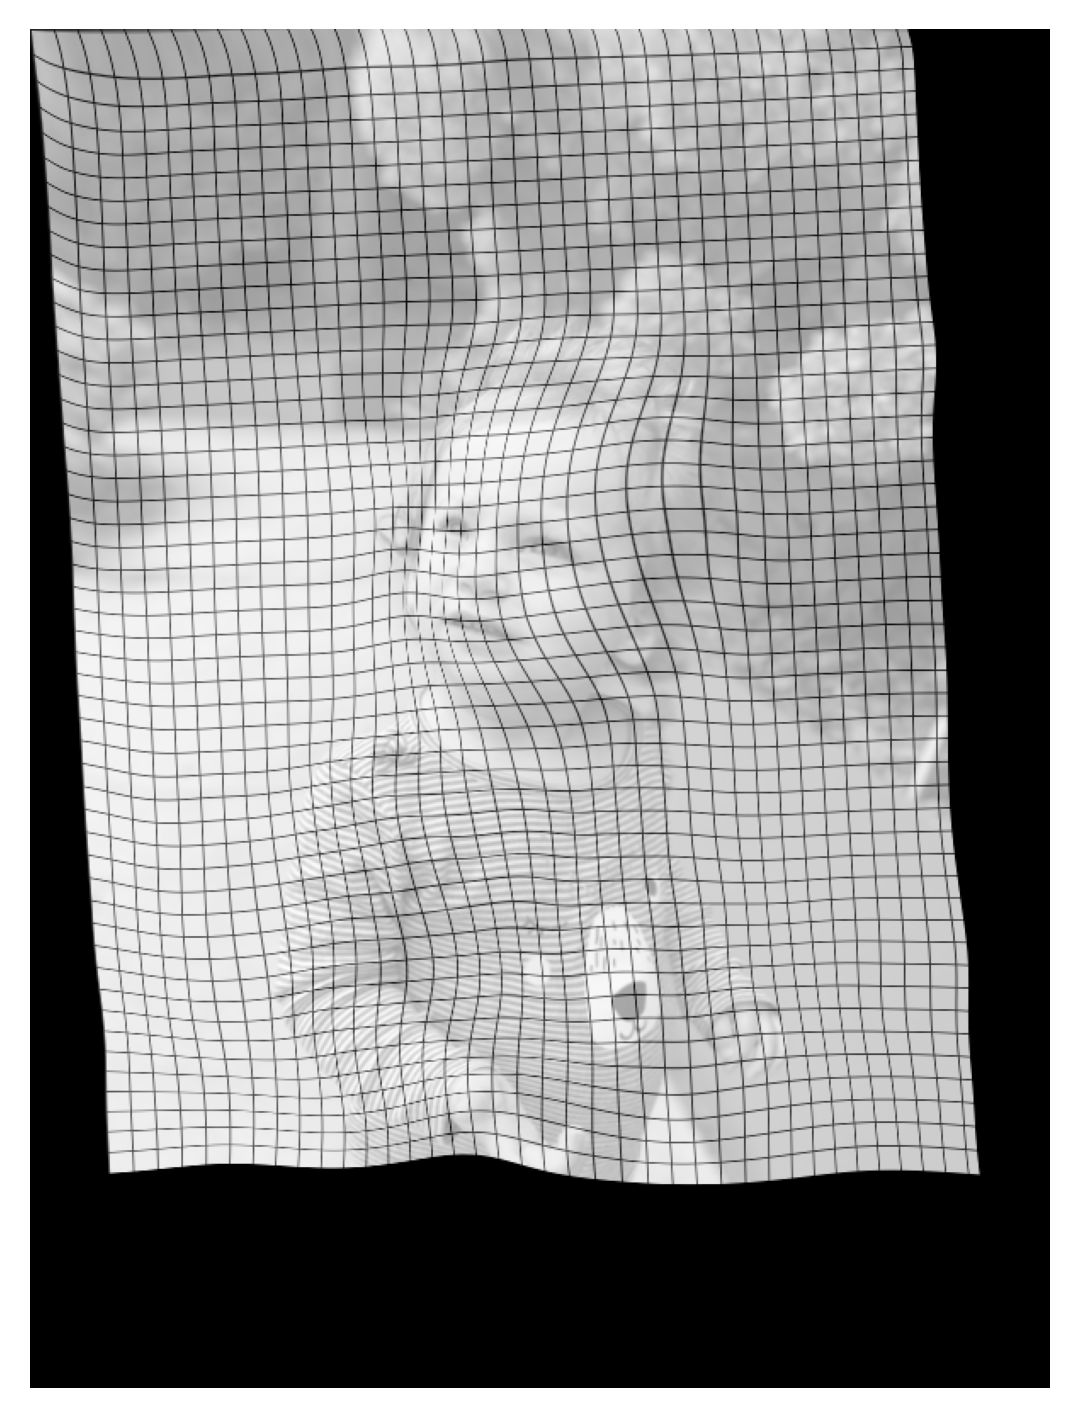

In [15]:
from ndslib.viz import plot_diffeomorphic_map
fig, ax = plt.subplots(figsize=(4, 4))
plot_diffeomorphic_map(mapping, ax)
im = ax.imshow(naomi2_warped, alpha=0.4)

(registration_ex1)=
#### Exercise

Write code to apply the diffeomorphic registration procedure to the brain-to-template registration problem. Note that this is a 3-dimensional problem, so you will need to initialize `metric = CCMetric(3)`.

Does the diffeomorphic registration resolve some of the issues we saw with affine registration? What problems do you think might arise when using diffeomorphic registration to register individual brains to a template?

## Summary

Image processing algorithms are used as key steps in many neuroimaging
processing pipelines. This chapter aimed to provide some intuition and the
language to understand what these algorithms do. It also provides a starting
point for thinking. Finally, the fundamentals of image processing provide a
necessary background for understanding some of the machine learning algorithms
that we will discuss in the next part.


### Additional resources

The book Elegant Scipy {cite}`nunez2017elegant` contains a chapter that explains the process of optimizing a registration between images using a cost function, with detailed code. The Jupyter notebook containing that chapter is also publicly available through [the book's GitHub repository](https://github.com/elegant-scipy/notebooks/blob/master/notebooks/ch7.ipynb).